In [1]:
import config
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import folium
import urllib
import regex as re
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt

# Determining Retail Categories to Open in Church Hill Neighborhood in Richmond, VA

## Table of Contents

0. [Introduction](#0)
1. [Data Collection](#1)\
    1.1 [Geographic Data Collection using Google Geocoder](#1.1)\
    1.2 [Retail Data Collection from Foursquare](#1.2)
2. [Data Cleaning and Preparation](#2)\
    2.1 [Remove Unwanted Foursquare Venue Entries](#2.1)\
    2.2 [Count the Number of Retail Venues in Each Neighborhood](#2.2)\
    2.3 [Remove Neighborhoods with minimal retail](#2.3)\
    2.4 [Create Dummy Feature Columns for Each Retail Category](#2.4)\
    2.5 [Scale the Feature Columns and Apply PCA Dimensionality Reduction](#2.5)
3. [Train the K-Means Clustering Model](#3)\
    3.1 [K-Means Clustering over a Range of Cluster Counts](#3.1)\
    3.2 [Use the Elbow Plot to Determine an Appropriate Number of Clusters, k](#3.2)\
    3.3 [Fit The K-Means Model](#3.3)\
    3.4 [Observe the Clusters](#3.4)
4. [Analysis and Conclusions](#4)\
    4.1 [Describe each Neighborhood Cluster with Bar Plots](#4.1)\
    4.2 [Compare Church Hill Retail to It's Cluster](#4.2)\
    4.3 [Conclusions for Church Hill](#4.3)\
    4.4 [Further Work](#4.4)
    


## 0 Introduction

The purpose of this project is to determine new retail that should open in the Church Hill neighborhood of Richmond, VA.  We will compare Church Hill's retail offerings to those of similar neighborhoods in Richmond and other nearby cities.  We can gather retail data on all the neighborhoods of Richmond and seven other nearby cities and use k-means clustering to place Church Hill in a group of similar neighborhoods.  We will then deduce the categories missing from Church Hill but found in high frequency within its cluster.  

expand on choice of church hill\
expand on data collection choices \
expand on model type choices\

<a id='1'></a>
## 1 Data Collection

<a id='1.1'></a>
### 1.1 Geographic Data Collection using Google Geocoder
We start by collecting a list of neighborhoods and their latitude, longitude coordinates.  I've decided to look at all the neighborhoods of Baltimore, Charlotte, Charlottesville, Norfolk, Raleigh, Richmond, Virginia Beach, and Washington, DC.

In [53]:
#An empty dataframe to collect the neighborhood data.
neigh_df=pd.DataFrame(columns=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])

In [42]:
#A function to plot the neighborhoods on a map.
def map_neigh(city,zoom, radius):
    lat_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'].mean()
    lng_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'].mean()

    f = folium.Figure(width=650, height=450)
    city_map = folium.Map(location=[lat_center,lng_center], zoom_start=zoom).add_to(f)

    # add markers to map
    for x,y, name in zip(neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [x,y],
            radius=radius,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(city_map)  

    return city_map

#### 1.1.1 Acquire Baltimore, MD neighborhood data

In [55]:
#Scrape wikipedia to generate a list of baltimore neighborhood names
bmd_page = requests.get('https://en.wikipedia.org/wiki/List_of_Baltimore_neighborhoods').text
bmd_soup = BeautifulSoup(bmd_page,'html.parser')
bmd_neigh=[]
neigh_search = bmd_soup.find_all('li')
for x in neigh_search[14:312]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in bmd_neigh:
        bmd_neigh.append(name)
bmd_neigh[261]='West Federal Hill'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in bmd_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Baltimore, MD"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Baltimore','State':'MD','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  West Hill Square


In [319]:
map_neigh('Baltimore',zoom=11,radius=250)

In [57]:
neigh_df.loc[neigh_df.City=='Baltimore','Radius']=250

#### 1.1.2 Acquire Charlotte, NC neighborhood data

In [58]:
#Scrape wikipedia to generate a list of Charlotte neighborhood names
cnc_page = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Charlotte,_North_Carolina').text
cnc_soup = BeautifulSoup(cnc_page,'html.parser')
cnc_neigh=[]
neigh_search = cnc_soup.find_all('li')
for x in neigh_search[1:34]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cnc_neigh:
        cnc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cnc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlotte, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlotte','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [320]:
map_neigh('Charlotte',zoom=10,radius=700)

In [60]:
neigh_df.loc[neigh_df.City=='Charlotte','Radius']=700

#### 1.1.3 Acquire Charlottesville, VA neighborhood data

In [61]:
#Scrape wikipedia to generate a list of charlottesville neighborhood names
cva_page = requests.get('https://www.cvillepedia.org/List_of_Charlottesville_neighborhoods').text
cva_soup = BeautifulSoup(cva_page,'html.parser')
cva_neigh=[]
neigh_search = cva_soup.find_all('li')
for x in neigh_search[5:23]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cva_neigh:
        cva_neigh.append(name)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlottesville, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlottesville','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [321]:
map_neigh('Charlottesville',zoom=12,radius=400)

In [63]:
neigh_df.loc[neigh_df.City=='Charlottesville','Radius']=400

#### 1.1.4 Acquire Norfolk, VA neighborhood data

In [64]:
#Scrape wikipedia to generate a list of norfolk neighborhood names
norva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Norfolk,_Virginia').text
norva_soup = BeautifulSoup(norva_page,'html.parser')
norva_neigh=[]
neigh_search = norva_soup.find_all('li')
for x in neigh_search[0:49]:
    norva_neigh.append(x.text)
norva_neigh[19]='Huntersville'
norva_neigh[3]='Bowling Green'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in norva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Norfolk, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Norfolk','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name) 

In [322]:
map_neigh('Norfolk',zoom=11,radius=400)

In [66]:
neigh_df.loc[neigh_df.City=='Norfolk','Radius']=400

#### 1.1.5 Acquire Raleigh, NC neighborhood data

In [67]:
#Scrape wikipedia to generate a list of raleigh neighborhood names
rgh_page = requests.get('https://en.wikipedia.org/wiki/Raleigh,_North_Carolina_neighborhoods').text
rgh_soup = BeautifulSoup(rgh_page,'html.parser')
rgh_neigh=[]
neigh_search = rgh_soup.find_all('li')
for x in neigh_search[4:109]:
    rgh_neigh.append(x.text)
    
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rgh_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Raleigh, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Raleigh','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  Westlake


In [323]:
map_neigh('Raleigh',zoom=11,radius=400)

In [69]:
neigh_df.loc[neigh_df.City=='Raleigh','Radius']=400

#### 1.1.6 Acquire Richmond, VA neighborhood data.

In [70]:
#Scrape wikipedia to generate a list of rva neighborhood names
rva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Richmond,_Virginia').text
rva_soup = BeautifulSoup(rva_page,'html.parser')
rva_neigh=[]
neigh_search = rva_soup.find_all('li')
for x in neigh_search[7:112]:
    rva_neigh.append(x.text)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Richmond, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Richmond','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [324]:
map_neigh('Richmond',zoom=11,radius=400)

In [72]:
neigh_df.loc[neigh_df.City=='Richmond','Radius']=400

#### 1.1.7 Acquire Virginia Beach, VA neighborhood data

In [73]:
#Here is the list of Virginia Beach neighborhoods
vab_neigh=['Alanton', 'Aragona Village', 'Bay Colony', 'Bayside', 'Cape Henry', 'Chesapeake Beach', 
               'Croatan Beach', 'Great Neck Point', 'Green Run', 'Kempsville', 'Lago Mar', 'Larkspur', 
               'London Bridge', 'Lynnhaven', 'Newtown', 'The North End', 'Oceana', 'Ocean Park', 'Pembroke Manor',
               'Princess Anne', 'Pungo', 'Red Mill Commons', 'Sandbridge', 'Thalia', 'Thoroughgood']

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in vab_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Virginia Beach, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Virginia Beach','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [325]:
map_neigh('Virginia Beach',zoom=10,radius=800)

In [75]:
neigh_df.loc[neigh_df.City=='Virginia Beach','Radius']=800

#### 1.1.8 Acquire Washington, DC neighborhood data

In [76]:
#Scrape wikipedia to generate a list of washington, dc neighborhood names
wdc_page = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Washington,_D.C.').text
wdc_soup = BeautifulSoup(wdc_page,'html.parser')
wdc_neigh=[]
neigh_search = wdc_soup.find_all('li')
for x in neigh_search[11:153]:
    name= re.sub(r"(| )\([^()]*\)", "", x.text)
    if name not in wdc_neigh:
        wdc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in wdc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Washington, DC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Washington','State':'DC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [326]:
map_neigh('Washington',zoom=11,radius=250)

In [78]:
neigh_df.loc[neigh_df.City=='Washington','Radius']=250

In [28]:
neigh_df.shape

(747, 6)

We've collected 747 total neighborhoods from the eight chosen cities.  We save all of this data to a csv file called neigh_df for safe keeping.  We will use the location data in neigh_df in the next section to find nearby retail venues.

In [79]:
#Save to csv file 
neigh_df.to_csv('neigh_df.csv',index=False)

<a id='1.2'></a>
### 1.2 Retail Data Collection from Foursquare

Now we collect all retail venues found within a radius of each neighborhood collected above.  I'm going to chose an appropriate radius for each city by roughly estimating based on the map views above.  Notice that more dense cities will have a smaller neighborhood radius.

In [107]:
neigh_df=pd.read_csv('neigh_df.csv')

In [ ]:
#A function to retrieve nearby retail venue data with the foursquare api.
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(df):
    
    venues_list=[]
    for neigh, city, state, lat, lng , radius in zip(df['Neighborhood'], df['City'],df['State'], df['Neighborhood Latitude'], df['Neighborhood Longitude'], df['Radius']):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            config.foursquare_id, 
            config.foursquare_secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neigh, 
            city,
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(neigh, end='\r')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'City',
                  'State',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [329]:
#View the retail venue data we just collected from all eight cities.
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place
...,...,...,...,...,...,...,...,...,...
5735,Starmount,Charlotte,NC,35.141693,-80.868220,Park South Station Pool and Fitness Club,35.145354,-80.864310,Club House
5736,Starmount,Charlotte,NC,35.141693,-80.868220,On The Go Mart,35.143072,-80.875201,Gas Station
5737,Stonehaven,Charlotte,NC,35.155497,-80.763010,"Quality Grill Parts, LLC",35.156302,-80.761389,Business Service
5738,Stonehaven,Charlotte,NC,35.155497,-80.763010,Betty Boos Treats,35.155218,-80.756179,Bakery


In [ ]:
#Collect all the retail locations by executing the function defined above.
venues_df=getNearbyVenues(neigh_df)

We've collected data on a total of 5740 retail venues from eight cities and 747 neighborhoods.  We'll save this data to a csv file called venues_df.

In [132]:
#Save venue data to csv file
venues_df.to_csv('venues_df.csv',index=False)

<a id='2'></a>
## 2 Data Cleaning and Preparation

In [20]:
#Read neighborhood and venue data from csv files
venues_df=pd.read_csv('venues_df.csv')
venues_df.shape

(5740, 9)

<a id='2.1'></a>
### 2.1 Remove Unwanted Foursquare Venue Entries
There are some venues collected from foursquare with category listed as neighborhood, housing developement, beach, lake, river, or building.  We're going to get rid of each of these venues because they do not represent any kind of relevant retail venue.

In [21]:
#Remove venues with trivial categories
venues_df=venues_df[venues_df['Venue Category']!='Neighborhood'] 
venues_df=venues_df[venues_df['Venue Category']!='Housing Development'] 
venues_df=venues_df[venues_df['Venue Category']!='Building'] 
venues_df=venues_df[venues_df['Venue Category']!='Beach'] 
venues_df=venues_df[venues_df['Venue Category']!='Lake'] 
venues_df=venues_df[venues_df['Venue Category']!='River'] 
venues_df.shape

(5683, 9)

This removed 57 unwanted venues with 5683 remaining.

<a id='2.2'></a>
### 2.2 Count the Number of Retail Venues in Each Neighborhood
There may be some neighborhoods with vastly different numbers of retail venues.  Let's count them for each neighorhood and look at the counts in a plot.

In [22]:
#Make a column venue count which counts the number of venues in each neighborhood
neigh_df = venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False)['Venue'].count()
neigh_df.columns = ['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude','Neighborhood Venue Count']
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
0,10th & Page,Charlottesville,VA,38.035116,-78.493400,14
1,Abell,Baltimore,MD,39.324474,-76.610944,4
2,Adams Morgan,Washington,DC,38.921242,-77.043493,52
3,Alanton,Virginia Beach,VA,36.880667,-76.024684,5
4,Allendale,Baltimore,MD,39.291798,-76.675200,1
...,...,...,...,...,...,...
579,Woodmoor,Baltimore,MD,39.338440,-76.733028,1
580,Woodridge,Washington,DC,38.933000,-76.968034,2
581,Woolen Mills,Charlottesville,VA,38.020366,-78.456190,5
582,Wyman Park,Baltimore,MD,39.330870,-76.627553,22


We see that only 584 of the 747 neighborhoods have at least one retail location on record.  

In [23]:
neigh_df.loc[neigh_df.Neighborhood=='Church Hill']

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
102,Church Hill,Richmond,VA,37.53284,-77.416252,15


We also see that Church Hill has 15 retail locations on record.  Let's make a histogram of the venue counts of the 587 remaining neighborhoods.

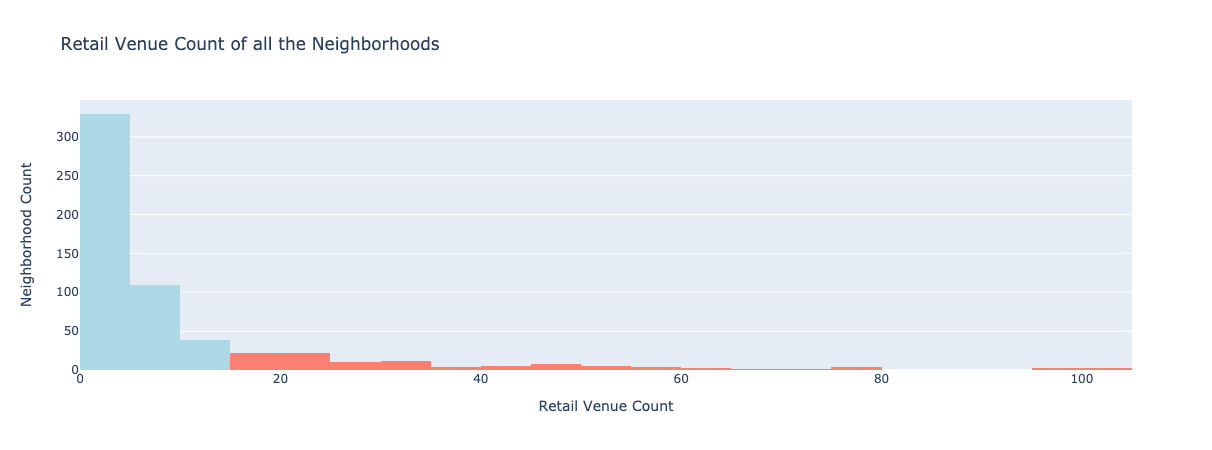

In [24]:
colors = ['salmon',] * 20
colors[0:2] = ['lightblue']*3

fig = go.Figure()
fig.add_trace(go.Histogram(x=neigh_df['Neighborhood Venue Count'],xbins=dict( #
        start=0,
        end=105,
        size=5),marker_color=colors))
fig.update_layout(title='Retail Venue Count of all the Neighborhoods',
                  xaxis_title='Retail Venue Count',
                  yaxis_title='Neighborhood Count'
                 )
fig.show()

There are 478 neighborhoods with less than 15 retail locations.  Since we are clustering to find similar neighborhoods, it would make sense to ignore these 478 neighborhoods with less than 15 retail locations *(because we are looking for expansion in the Church Hill neighborhood.)*

<a id='2.3'></a>
### 2.3 Remove Neighborhoods with Minimal Retail

In [25]:
#add the venue count column to the venues_df
venues_df=venues_df.merge(neigh_df,on=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])
#Remove neighborhoods with less than 15 retail venues
venues_df = venues_df[(venues_df['Neighborhood Venue Count']>=15)]
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Venue Count
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café,23
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place,23
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega,23
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant,23
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place,23
...,...,...,...,...,...,...,...,...,...,...
5673,SouthPark,Charlotte,NC,35.148448,-80.830896,Gymboree,35.152143,-80.832488,Kids Store,100
5674,SouthPark,Charlotte,NC,35.148448,-80.830896,Dairy Queen,35.153833,-80.828647,Ice Cream Shop,100
5675,SouthPark,Charlotte,NC,35.148448,-80.830896,Planet Smoothie,35.152843,-80.832594,Smoothie Shop,100
5676,SouthPark,Charlotte,NC,35.148448,-80.830896,Aéropostale,35.153046,-80.832473,Clothing Store,100


With 3846 retail venues remaining, we've removed 1837 retail venues by removing all the neighborhoods with less than 15 retail venues.

<a id='2.4'></a>
### 2.4 Create Dummy Feature Columns for Each Retail Category
Now we will group all our venue data by neighborhood, create a column for every possible retail venue category, and insert the frequency of occurance of that category for each neighborhood as a percent.  This frequency comes from taking the mean of 0's and 1's where 0 is not present and 1 is present.  

In [26]:
#Make dummy columns on the venues_df
venues_df=pd.get_dummies(venues_df, columns= ['Venue Category'], prefix="", prefix_sep="") 
#Take the mean of each dummy column grouped by neighborhood to get the retail category frequency (percent)
neigh_df=venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False).mean().drop(labels=['Venue Latitude','Venue Longitude'],axis=1)
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,ATM,Accessories Store,Afghan Restaurant,African Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Adams Morgan,Washington,DC,38.921242,-77.043493,52,0.0,0.0,0.019231,0.0,...,0.0,0.0,0.0,0.0,0.019231,0.000000,0.0,0.0,0.0,0.000000
1,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,Arts District,Richmond,VA,37.543453,-77.438963,23,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,Bayside,Virginia Beach,VA,36.902925,-76.134380,34,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,Bellevue,Richmond,VA,37.590832,-77.457554,15,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,West Raleigh Historic District,Raleigh,NC,35.777619,-78.638765,78,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.012821
102,Westhampton,Richmond,VA,37.574101,-77.514645,19,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.052632
103,Wilder's Grove,Raleigh,NC,35.798804,-78.564528,19,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
104,Willow Lawn,Richmond,VA,37.581870,-77.497587,39,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


Notice we have 106 neighborhoods and 309 dummy feature columns based on retail venue category.  We will also use the Neighborhood Venue Count column as a feature in our clustering since the number of retail venues in a neighborhood can characterize the neighborhood.

<a id='2.5'></a>
### 2.5 Scale the Feature Columns and Apply PCA Dimensionality Reduction

In order to prepare our data for k-means clustering, we are going to process it in two ways.  First we will apply a standard scaler to give each feature a mean of 0 and a variance of 1.  Next, we will apply dimensionality reduction with Principle Component Analysis or PCA.  The reason for this is because our data is quite sparse with most entries being zero and with there being more feature columns than sample rows.  This sparse data is likely going to introduce a great deal of noise and using PCA will reduce this by projecting our data down to its most important components.

In [27]:
#Standard scaler gives each feature a mean 0 with variance 1
scaled_features = StandardScaler().fit_transform(neigh_df.values[:,5:])

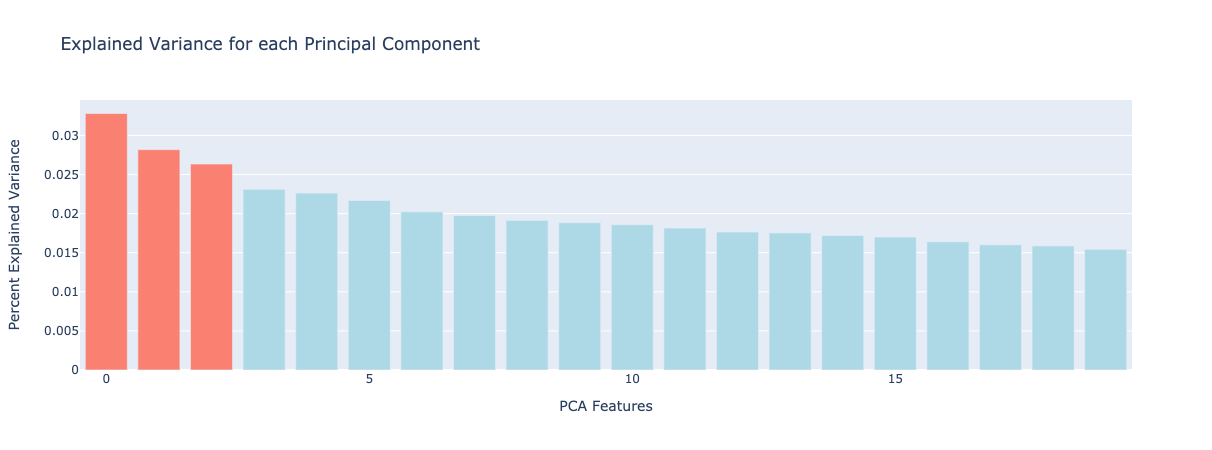

In [28]:
#Apply Principal Component Analysis for dimensionality reduction
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features)
features = list(range(pca.n_components_))

colors = ['lightblue',] * 30
colors[0:2] = ['salmon']*3

fig = go.Figure()
fig.add_trace(go.Bar(x=features,y=pca.explained_variance_ratio_,marker_color=colors))
fig.update_layout(title='Explained Variance for each Principal Component',
                  xaxis_title='PCA Features',
                  yaxis_title='Percent Explained Variance',
                 )
fig.show()

We have a bit of a drop in variance after the first three components which means we we can plot the first three components and see a good amount of the overall variance.

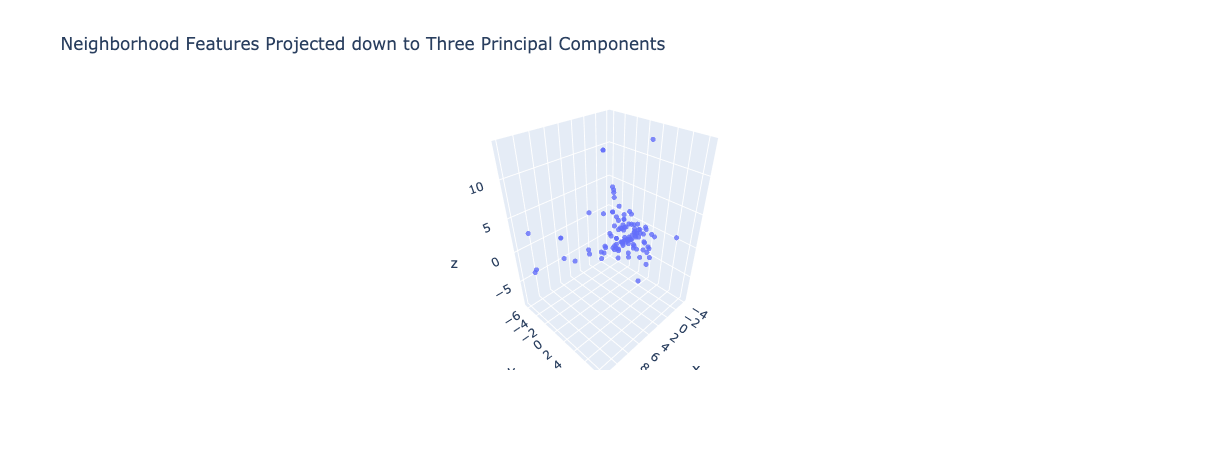

In [29]:
pca_df=pd.DataFrame(principalComponents)
pca_df.insert(loc=0,column='Neighborhood',value=neigh_df['Neighborhood']+', '+neigh_df['City']+', '+neigh_df['State'])

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_df[0],y=pca_df[1],z=pca_df[2],
                            hovertemplate=pca_df['Neighborhood'],
                            mode='markers',
                            opacity=0.8,
                            marker_size=3))
fig.update_layout(title='Neighborhood Features Projected down to Three Principal Components')

fig.show()

This data in three dimensions is what we will cluster with the k-means algorithm.  As stated above, we've reduced the dimensionality of our data to reduce noise caused by the sparsity of dummy features.

<a id='3'></a>
## 3 Train the K-Means Clustering Model

<a id='3.1'></a>
### 3.1 K-Means Clustering over a Range of Cluster Counts, k
We will apply the k-means clustering algorithm to the 106 neighborhoods with 15 or more retail venues.  We'll do so over a range of cluster counts k from 3 to 25 to determine the best choice.  With each model we can record the inertia or the sum of the squared distances from each point to it's centroid, the center of its cluster.

In [30]:
kmin=3
kmax=25

#Define a kmeans model
kmeans = KMeans(init='k-means++',random_state=1)
#Define an empty list to save error values (we will use the silhouette coefficient)
inertia_list = []
for k in range(kmin,kmax):
    kmeans.set_params(n_clusters=k)
    kmeans.fit(pca_df.iloc[:,1:4])
    inertia_list.append(kmeans.inertia_)
df=pd.DataFrame({'k':range(kmin,kmax),'inertia':inertia_list})

<a id='3.2'></a>
### 3.2 Use the Elbow Plot to Determine an Appropriate Number of Clusters, k
Minimizing this intertia measurement is one way to indicate a good clustering, however inertia will always continue to decrease as the cluster count increases.  Therefore, we will look for an elbow point in the interia plot below which indicates a point where increasing the cluster count has diminishing returns.  

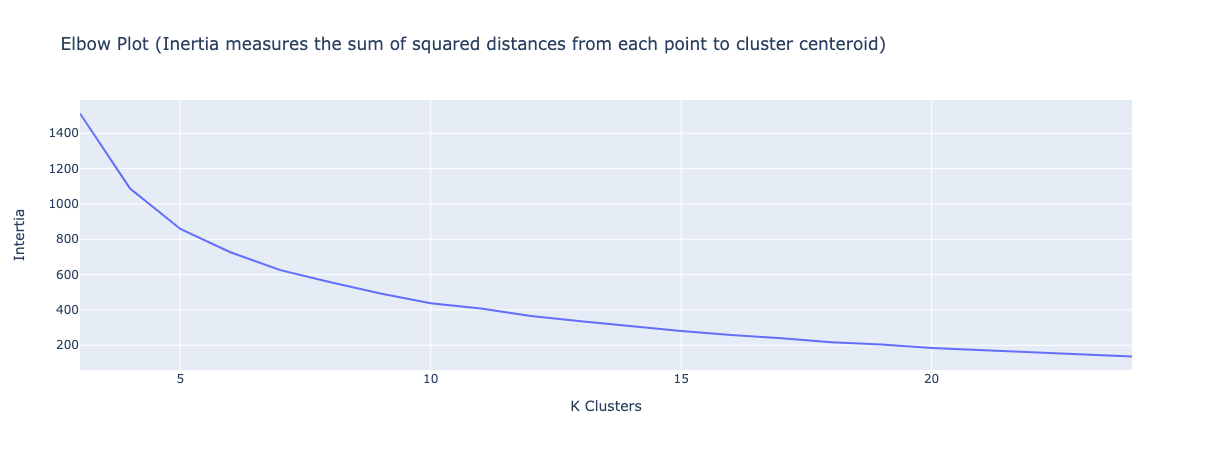

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['k'],y=df['inertia'],mode='lines'))
fig.update_layout(title='Elbow Plot (Inertia measures the sum of squared distances from each point to cluster centeroid)',
                 xaxis_title='K Clusters',
                 yaxis_title='Intertia')
fig.show()

*Mention that 4-7 would all be decent choices and clearly better than 3 becuase..*

There is no significant elbow represented here which may indicate our model does not have clearly defined clusters.  We could see in our 3D plot earlier that this is true.  Still, we may choose k=5 clusters as there does appear to be a bit of an elbow there.  This means our algorithm will group the 106 neighborhoods into five clusters.

<a id='3.3'></a>
### 3.3 Fit The K-Means Model
We've chosen to use five clusters for our k-means model based on the inertia measurements in the elbow plot above.

In [32]:
kmeans = KMeans(init="k-means++", n_clusters=5,random_state=1)
kmeans.fit(pca_df.iloc[:,1:4])

KMeans(n_clusters=5, random_state=1)

<a id='3.4'></a>
### 3.4 Observe the Clusters
We can plot our data with reduced dimensionality again, this time with the results of our clustering respented in color.

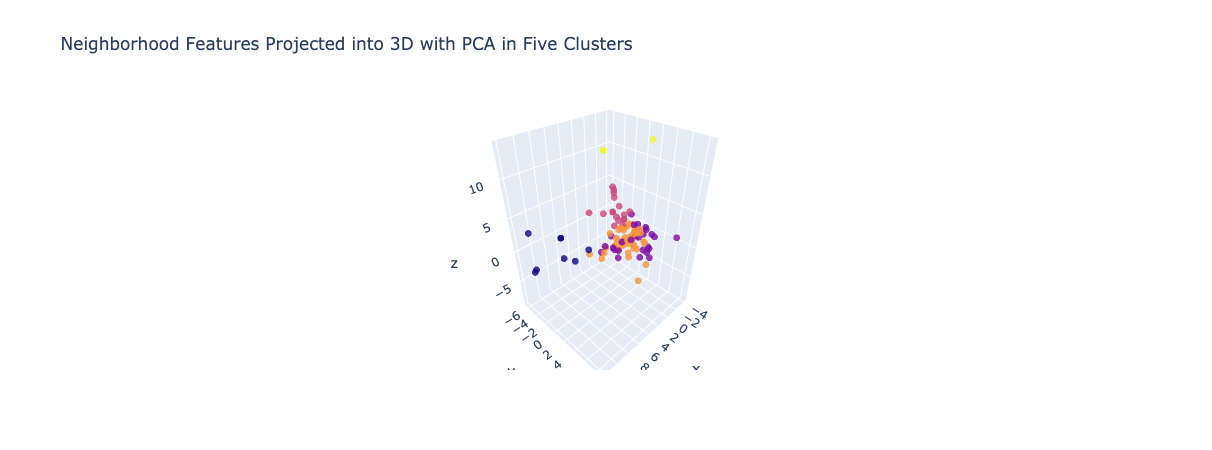

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_df[0],y=pca_df[1],z=pca_df[2],
                            marker_color=kmeans.labels_,
                           customdata=kmeans.labels_,
                            text=pca_df['Neighborhood'],
                           hovertemplate='<br>Cluster %{customdata} <br>%{text}',
                            mode='markers',
                            opacity=0.8,
                            marker_size=4))
fig.update_layout(title='Neighborhood Features Projected into 3D with PCA in Five Clusters')

fig.show()


Let's first look at how many neighborhoods were placed into each cluster.  Right away we can see that some clusters are larger than others.  For instance, Cluster 0 and 4 seem to consist of outlier neighborhoods.

In [34]:
neigh_df.insert(loc=6, column='Cluster Label', value= kmeans.labels_)
neigh_df.groupby('Cluster Label').count()[['Neighborhood']]

,Neighborhood
Cluster Label,
0,8
1,28
2,17
3,50
4,3


Now we should find out what Church Hill's cluster of neighborhoods looks like.  First we find out Church Hill's label, and then we pull up all the neighborhoods with this label.

In [35]:
neigh_df.loc[neigh_df['Neighborhood']=='Church Hill']

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
18,Church Hill,Richmond,VA,37.53284,-77.416252,15,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Church Hill was put into cluster 3.  We expect to see 50 neighborhoods in this cluster, so let's list them now.

In [36]:
neigh_df.loc[neigh_df['Cluster Label']==3].sort_values(by=['City','Neighborhood'])

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
6,Bromo Arts District,Baltimore,MD,39.294943,-76.619813,22,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Canton,Baltimore,MD,39.282183,-76.576276,16,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,Cathedral Hill,Baltimore,MD,39.299596,-76.617173,33,3,0.0,0.0,0.030303,...,0.000000,0.0,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000
15,Charles Center,Baltimore,MD,39.289391,-76.615686,31,3,0.0,0.0,0.000000,...,0.032258,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,Downtown,Baltimore,MD,39.292007,-76.616721,29,3,0.0,0.0,0.000000,...,0.034483,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,Federal Hill,Baltimore,MD,39.279304,-76.611666,23,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34,Four by Four,Baltimore,MD,39.282519,-76.602252,24,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000
40,Harbor East,Baltimore,MD,39.283225,-76.601556,28,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000
43,Hilton,Baltimore,MD,39.285922,-76.621451,30,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44,Inner Harbor,Baltimore,MD,39.285848,-76.613110,45,3,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


I'm going to save these cluster labels to a new csv file for safe keeping.

In [37]:
neigh_df_clustered=neigh_df
neigh_df_clustered.to_csv('neigh_df_clustered.csv',index=False)

<a id='4'></a>
## 4 Analysis and Conclusions

In [38]:
neigh_df=pd.read_csv('neigh_df_clustered.csv')

<a id='4.1'></a>
### 4.1 Describe each Neighborhood Cluster with Bar Plots
Here we can rank each retail venue category left to right and plot average frequency in a bar graph for each neighborhood cluster.

In [39]:
#Define a function to plot the cluster categories frequencies
def plot_cluster(df,cluster_num):
    cluster_df=df.groupby('Cluster Label')[df.columns[7:]].mean().iloc[cluster_num,:].to_frame()
    cluster_df=cluster_df.sort_values(by=cluster_num,ascending=False)[0:60]
    
    fig = go.Figure()

    fig.add_trace(go.Bar(
    x=cluster_df.index,
    y=cluster_df[cluster_num],
    name=str(['Cluster ',cluster_num]),
    ))
    fig.update_layout(title='Ranked Retail Categories of Neighborhood Cluster '+str(cluster_num),
        yaxis_title='Average Frequency')
    fig.show()
    print('Neighborhoods: ',neigh_df.loc[neigh_df['Cluster Label']==cluster_num]['Neighborhood'].to_list())

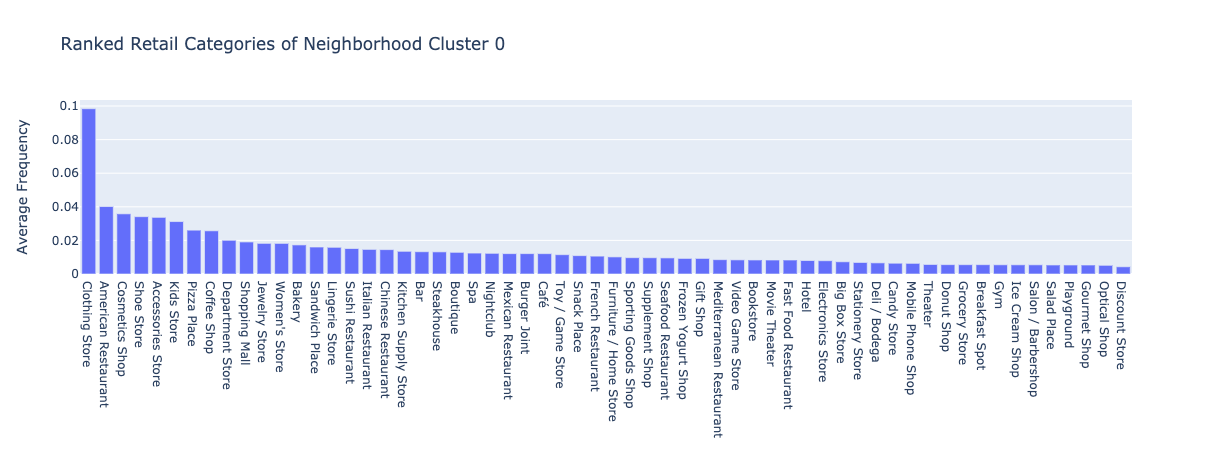

Neighborhoods:  ['Crabtree Valley', 'Downtown Norfolk', 'North Hills', 'Pembroke Manor', 'SouthPark', 'Stoney Point', 'Tidewater Park', 'Wards Corner Business District']


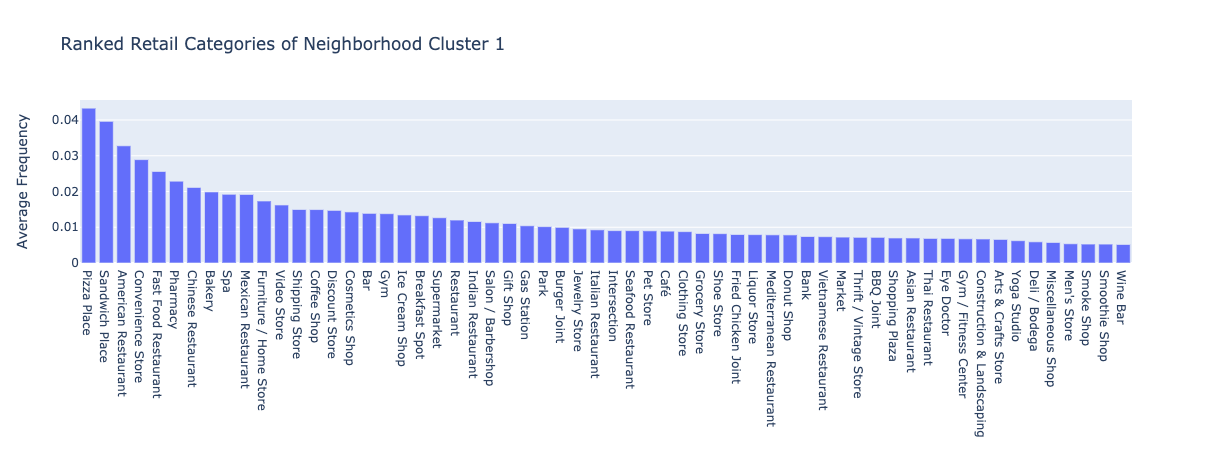

Neighborhoods:  ['Bayside', 'Brier Creek', 'Cameron Village', 'Carytown', 'Cherry', 'Cottage Road Park', 'Dilworth', 'Elizabeth', 'Georgetown', 'Glenwood-Brooklyn', 'Green Run', 'Highland Park', 'Kempsville', 'Leesville', 'London Bridge', 'Lynnhaven', 'Mount Vernon', 'Newtown', 'North Ridge Country Club', 'Olde Raleigh', 'Red Mill Commons', 'Riverview', 'Sedgefield', 'Thalia', 'Westhampton', "Wilder's Grove", 'Willow Lawn', 'Wyman Park']


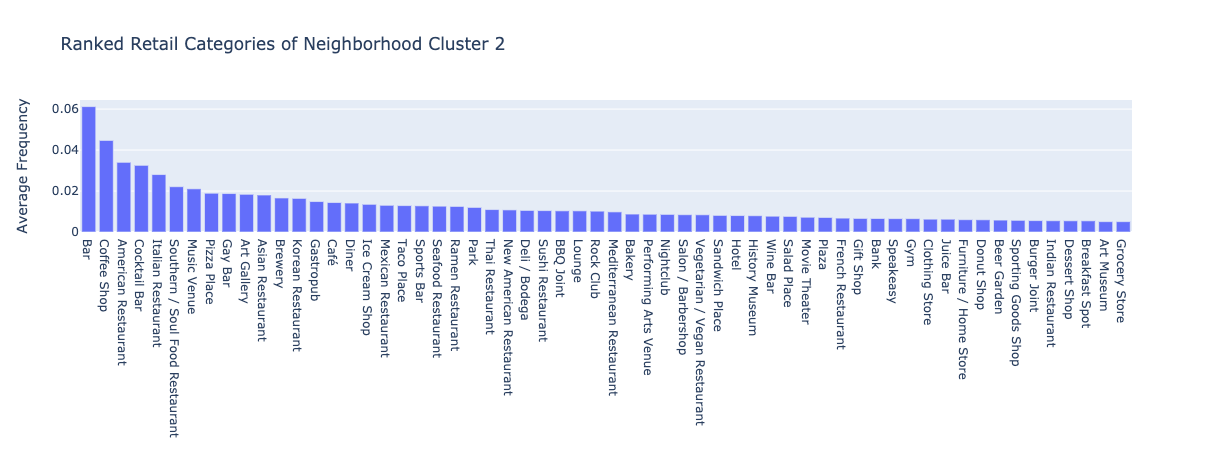

Neighborhoods:  ['Adams Morgan', 'Capitol District', 'Capitol Heights', 'Chinatown', 'Depot District', 'Fayetteville Street', 'Fells Point', 'Freemason District', 'Jackson Ward', 'Moore Square', 'NoDa', 'Old Goucher', 'Old North Charlotte', 'Penn Quarter', 'U Street Corridor', 'Warehouse District', 'West Raleigh Historic District']


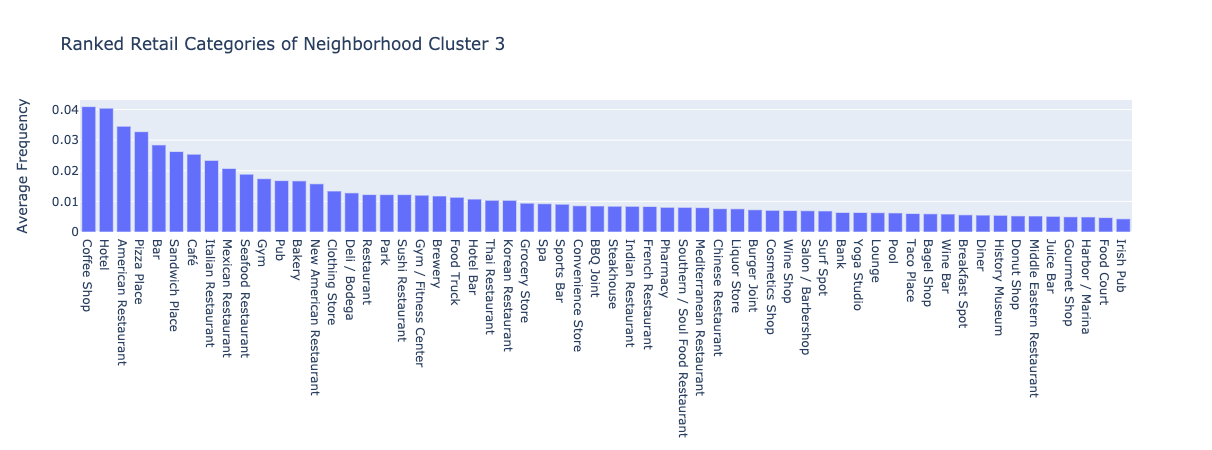

Neighborhoods:  ['Aragona Village', 'Arts District', 'Bellevue', 'Bromo Arts District', 'Brooklyn', 'Canton', 'Capitol Hill', 'Cathedral Hill', 'Charles Center', 'Church Hill', 'City Center', 'Croatan Beach', 'Downtown', 'Downtown', 'Dupont Circle', 'Federal Hill', 'Federal Triangle', 'Four by Four', 'Glenwood South', 'Harbor East', 'Hi-Mount', 'Hilton', 'Inner Harbor', 'Ivy City', 'Kalorama', 'Little Italy', 'Madison Park, Charlotte', 'Maiden Lane', 'Midtown-Belvedere', 'Mount Vernon Square', 'Mount Vernon Triangle', 'Navy Yard', 'Observatory Circle', 'Ocean Park', 'Preston Gardens', 'Remington', 'Rose Hill', "Scott's Addition", 'Sheridan Kalorama', 'Shockoe Bottom', 'Shockoe Slip', 'South Balto.Imp.Comm./West Federal Hill', 'South End', 'Southwest Federal Center', 'Starr Hill', 'Three Corners', 'Tobacco Row', 'Uptown Charlotte', 'West End', 'West Freemason']


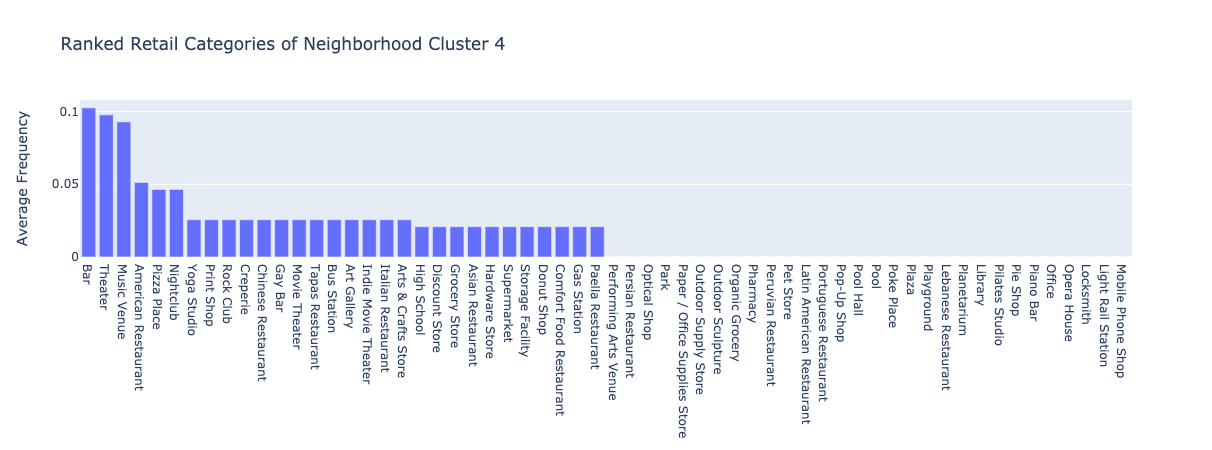

Neighborhoods:  ['Newtowne West', 'Station North', 'Station North Arts and Entertainment District']


In [40]:
#Make a plot for all five clusters
for k in range(5):
    plot_cluster(neigh_df,k)

<a id='4.2'></a>
### 4.2 Compare Church Hill Retail to It's Cluster

In [41]:
#Define a function to plot a neighborhood's retail venue category frequencies over the average frequencies of its cluster.
def plot_missing(df,neigh_name,cluster_num):
    neigh_freq=df.loc[df['Neighborhood']==neigh_name].iloc[:,7:]
    cluster_df=df.groupby('Cluster Label')[df.columns[7:]].mean().iloc[cluster_num,:].to_frame()
    cluster_df.insert(loc=1,column=neigh_name,value=neigh_freq.T)
    cluster_df=cluster_df.sort_values(by=cluster_num,ascending=False)[0:60]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
    x=cluster_df.index,
    y=cluster_df[cluster_num],
    name=str(['Cluster ',cluster_num]),
    ))
    fig.add_trace(go.Bar(
    x=cluster_df.index,
    y=cluster_df[neigh_name],
    name=neigh_name,
    opacity=0.7
    ))

    fig.update_layout(barmode='overlay',
                     title='Ranked Retail Categories of Neighborhood Cluster '+str(cluster_num)+' vs. '+neigh_name+' Neighborhood',
                     yaxis_title='Average Frequency')
    fig.show()

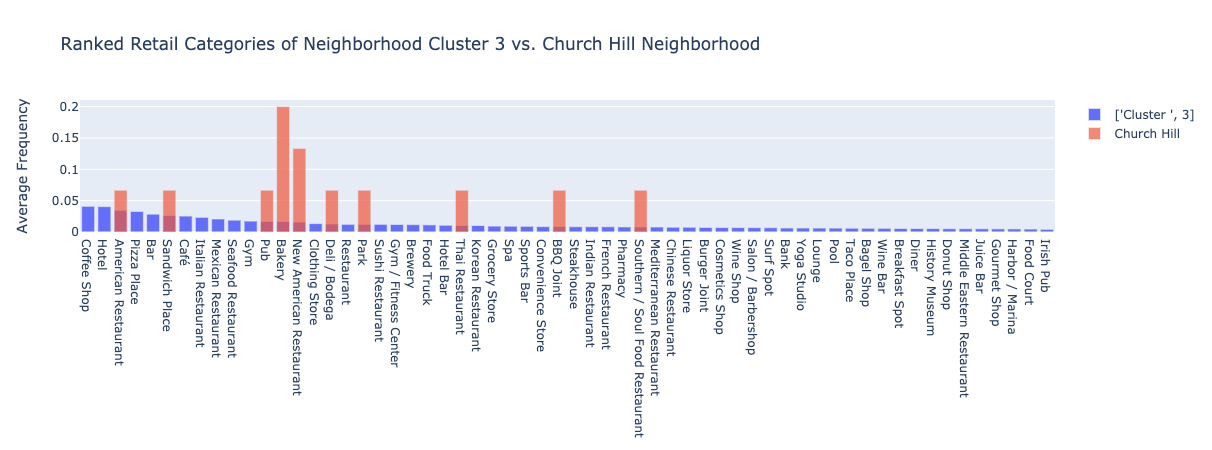

In [52]:
#Execute plot function for Church Hill and its cluster
plot_missing(neigh_df,'Church Hill',3)

<a id='4.3'></a>
### 4.3 Conclusions for Church Hill

*(Repeat business question)*

*Try LISTING the missing retail instead of in a sentence.*

We gather from the plot above that the Church Hill neighborgood would likely do well to add any one of the follow types of retail: coffee shop, hotel, pizza place, bar, cafe, Italian Restaurant, Seafood Restaurant, Gym, clothing store, sushi restaurant, just to name the top ten. This is based on the fact that 49 other nearby neighborhoods with similar retail tend to include these categories in higher frequency.

<a id='4.4'></a>
### 4.4 Further Work

The biggest problem we faced here was sparse data. There are mostly zeros in the data and more feature columns than sample rows (106 neighborhoods and 309 dummy feature columns).  PCA was a good way to improve the clustering because we were able to reduce potential noise from sparse data by reducing dimensionality.  Another method to look into is entropy-weighted k-means clustering which is supposed to handle sparse data with an excessive number of features quite well.

I could also look to decrease the sparsity of data in numerous ways.  I could add a wider variety of data to characterize each neighborhood.  This data could be median house price, median income, political party affiliation of local representatives, or population density.  Any one of these features could likely aid to characterize a retail market. 

Another interesting way that I could decrease sparsity in the data would not require going beyond Foursquare.  Instead, I could improve the quality of the retail venue category labels by considering a hierarchy of parent categories and sub-categories defined by a Foursquare API documentation webpage.  Some retail venues are only given a broad category such as Restaurant.  Then other venues are given a category such as American Restuarant versus New American Restaurant which are considered as different as any other categories, despite being similar or essentially same.  If each retail venue were labeled with it's assigned category and all of its parent categories, then for example the American Restaurant and the New American Restaurant would now share at least parent category and maybe more.  Then the retail venues would be better represented and the data would be less sparse.  I would be interested to see what the decrease in sparsity would look like.  Unfortunately, gathering these parent categories doesn't seem to be built into Foursquares API, but this could still be done with a tree data structure and a function on my end. 


In [335]:
!git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.44 KiB | 1.44 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/mphill82/Retail_Inference_Capstone.git
To https://github.com/mphill82/Coursera_Capstone.git
   d2d262c..782d872  master -> master
